# 使用PaddleHub实现人脸风格迁移

---------------------------------------------------------------------------------------------------
本项目使用百度的预处理工具PaddleHub，利用人脸检测模型pyramidbox_face_detection和艺术风格迁移模型stylepro_artistic，尝试进行人脸的风格迁移。首先利用pyramidbox_face_detection分割出人脸并保存，然后利用stylepro_artistic进行风格迁移。
文件夹的结构为：
* contentImages保存的是要进行风格迁移的图片
* styleImages保存的是要使用的风格图片
* contentResult保存的是要进行风格迁移的人脸图片
* styleResult保存的是要使用的风格人脸图片
* transfer_result保存的是最后完成风格迁移的人脸图片


In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

In [ ]:
# # 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# # If a persistence installation is required, you need to use the persistence path as the following:
# !mkdir /home/aistudio/external-libraries
# #安装paddlehub
!pip install paddlehub==1.6.0 -i https://pypi.tuna.tsinghua.edu.cn/simple -t /home/aistudio/external-libraries

In [2]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
# Also add the following code, so that every time the environment (kernel) starts, just run the following code:
import sys
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

### 安装人脸检测模型和风格迁移模型

In [ ]:
!hub install pyramidbox_face_detection==1.0.0
!hub install stylepro_artistic==1.0.0

In [12]:
import paddlehub as hub
import cv2
import os
from PIL import Image

In [9]:
detection_module = hub.Module(name="pyramidbox_face_detection")
style_module = hub.Module(name="stylepro_artistic")

[2020-06-07 01:18:35,917] [    INFO] - Installing pyramidbox_face_detection module
[2020-06-07 01:18:35,938] [    INFO] - Module pyramidbox_face_detection already installed in /home/aistudio/.paddlehub/modules/pyramidbox_face_detection
[2020-06-07 01:18:36,259] [    INFO] - Installing stylepro_artistic module
[2020-06-07 01:18:36,279] [    INFO] - Module stylepro_artistic already installed in /home/aistudio/.paddlehub/modules/stylepro_artistic


### 人脸检测处理函数

In [17]:
def face_process(source_path, target_path):
    for img_path in os.listdir(source_path):
        if img_path != '.ipynb_checkpoints':        
            path = os.path.join(source_path, img_path)
            img = Image.open(path)
            width,height = img.size
        
            input_dict = {"image": [path]}
        
            results = detection_module.face_detection(data=input_dict)
            for result in results:
                # print(result['path'])
                # print(result['data'])
                x1 = int(result['data'][0]['left'] * width)
                y1 = int(result['data'][0]['top'] * height)
                x2 = int(result['data'][0]['right'] * width)
                y2 = int(result['data'][0]['bottom'] * height)
                img_crop_result = img.crop((x1,y1,x2,y2))
                saved_path = os.path.join(target_path, img_path)
                # print(saved_path)
                img_crop_result.save(saved_path)
                print('pic saved to ' + saved_path)

### 将内容图片和风格图片提取人脸后存到相应的文件夹

In [26]:
face_process('work/contentImages', 'work/contentResult')
face_process('work/styleImages', 'work/styleResult')

The image with bbox is saved as ./output/fengjie.jpg
pic saved to work/contentResult/fengjie.jpg
The image with bbox is saved as ./output/gaoyuanyuan.jpg
pic saved to work/styleResult/gaoyuanyuan.jpg


### 风格处理函数

In [47]:
def style_process(content_path, style_path):
    content_list = [os.path.join(content_path, path) for path in os.listdir(content_path) if path != '.ipynb_checkpoints']
    styles_list = [os.path.join(style_path, path) for path in os.listdir(style_path)      if path != '.ipynb_checkpoints']
    for i in range(len(content_list)):
        content = cv2.imread(content_list[i])
        styles = cv2.imread(styles_list[i])
        result = style_module.style_transfer(
            images=[{
                'content': content,
                'styles': [styles]
            }],
            alpha=1,
            visualization=True,
            output_dir='work/transfer_result'
        )     
    print('Finished style transfer!')

In [48]:
style_process('work/contentResult', 'work/styleResult')

Finished style transfer!


### 转换前的内容图片和风格图片

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

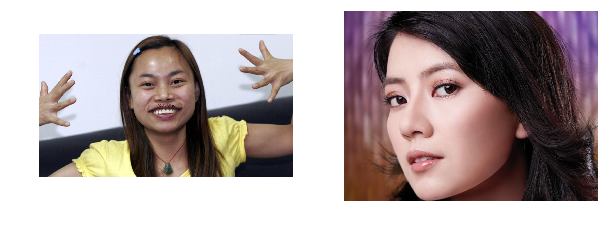

               content image                            style image


In [43]:
content_before = mpimg.imread('work/contentImages/fengjie.jpg')
style_before = mpimg.imread('work/styleImages/gaoyuanyuan.jpg')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(content_before)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(style_before)
plt.axis('off')
plt.show()
print("               content image                            style image")

### 提取的内容人脸图片和风格人脸图片

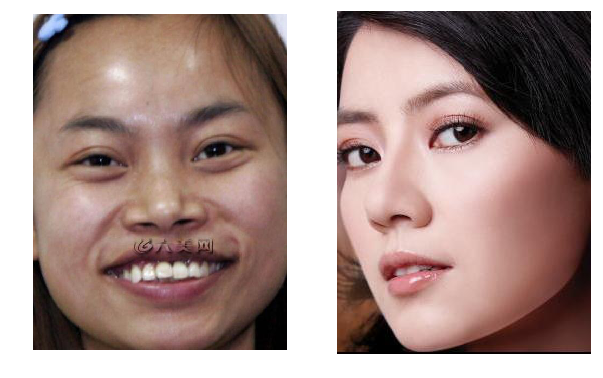

               content face                            style face


In [45]:
content_face = mpimg.imread('work/contentResult/fengjie.jpg')
style_face = mpimg.imread('work/styleResult/gaoyuanyuan.jpg')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(content_face)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(style_face)
plt.axis('off')
plt.show()
print("               content face                            style face")

### 转换后的内容人脸图片和其风格人脸图片

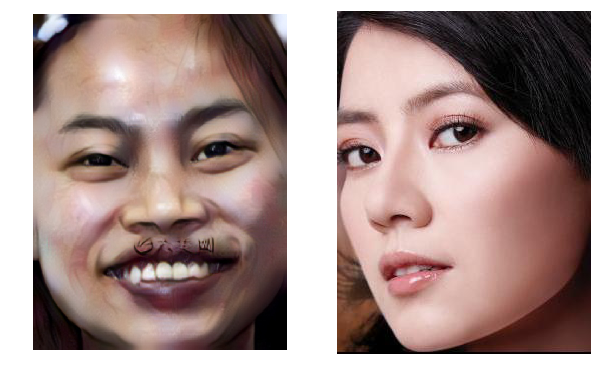

               result image                            style image


In [49]:
content_after = mpimg.imread('work/transfer_result/' + os.listdir('work/transfer_result')[0])
style = mpimg.imread('work/styleResult/gaoyuanyuan.jpg')
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(content_after)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(style)
plt.axis('off')
plt.show()
print("               result image                            style image")